In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence

#Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_theme(style="whitegrid")

In [68]:
df = pd.read_csv('../Data Source/final_merge.csv')
df['bb_int_struct'] = df['bb_int_struct'] * 100

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   county                      3076 non-null   object 
 1   state                       3076 non-null   object 
 2   ruca                        3073 non-null   float64
 3   brfss_access2_ageadjprv     3076 non-null   float64
 4   brfss_checkup_ageadjprv     3076 non-null   float64
 5   brfss_csmoking_ageadjprv    3076 non-null   float64
 6   brfss_depression_ageadjprv  3076 non-null   float64
 7   brfss_diabetes_ageadjprv    3076 non-null   float64
 8   brfss_ghlth_ageadjprv       3076 non-null   float64
 9   brfss_mhlth_ageadjprv       3076 non-null   float64
 10  brfss_obesity_ageadjprv     3076 non-null   float64
 11  brfss_access2_ageadjprv.1   3076 non-null   float64
 12  brfss_checkup_ageadjprv.1   3076 non-null   float64
 13  brfss_csmoking_ageadjprv.1  3076 

In [81]:
primary_dv = [
    'brfss_diabetes_ageadjprv' 
]
dv_struct = [
    'pct_dg_bb_int'
]
structural = [
    'bb_int_struct', #Social Policies | Soceieconomic and Political Context
    'pct_sex_male', #SES | Demographics 
    #'pct_sex_female', #SES | Demographics Commented out as reference
    #'pct_ed_lt9', #SES | Education Commented out as reference
    'pct_ed_9_12', #SES | Education
    'pct_ed_hs', #SES | Education
    'pct_ed_sc', #SES | Education
    'pct_ed_asc', #SES | Education
    'pct_ed_b', #SES | Education
    'pct_ed_gr', #SES | Education
    'pct_race_white', #SES | Demographics
    'pct_race_black', #SES | Demographics
    'pct_race_aian', #SES | Demographics
    'pct_race_nhopi', #SES | Demographics
    'pct_race_other', #SES | Demographics
    #'pct_occ_unemp', #SES | Occupation
    'pct_occ_mgt', #SES | Occupation
    'pct_occ_svc', #SES | Occupation
    'pct_occ_sales', #SES | Occupation
    'pct_occ_nat_res', #SES | Occupation
    'pct_occ_prod', #SES | Occupation
    'pct_ses_pov', #SES | Income
    #'ruca_metro', #SES | Geography Commented out as reference
    'ruca_micro', #SES | Geography
    'ruca_small_town', #SES | Geography
    'ruca_rural' #SES | Geography
]


                            OLS Regression Results                            
Dep. Variable:          pct_dg_bb_int   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     217.4
Date:                Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:15:08   Log-Likelihood:                -9268.7
No. Observations:                3076   AIC:                         1.858e+04
Df Residuals:                    3053   BIC:                         1.872e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              80.4906      0.089    9

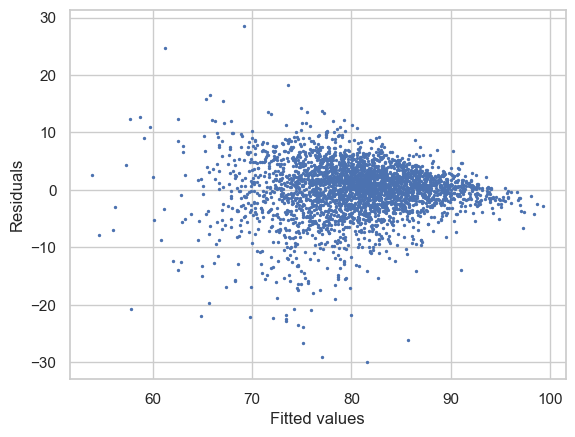

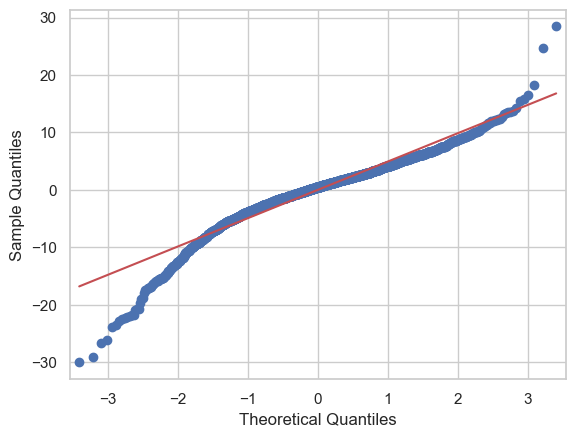

Mean Absolute Error: 3.5238505796138595
Root Mean Squared Error: 4.924847711536969


In [104]:
X_struct = df[structural]
X_struct = X_struct - X_struct.mean()
X_struct = sm.add_constant(X_struct)

y = df[dv_struct]

model = sm.OLS(y, X_struct).fit()

df['structural_internet_adoption'] = model.predict(X_struct)
#export to csv named 'final_data_with_structural_predictions.csv'
df.to_csv('../Data Source/final_data_with_structural_predictions.csv', index=False)

#model summary
print(model.summary())

#plto residuals
fig, ax = plt.subplots()
ax.scatter(model.fittedvalues, model.resid, s=2) 
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
plt.show()

#QQ plot
fig, ax = plt.subplots()
sm.qqplot(model.resid, line='s', ax=ax)
plt.show()

mae = np.mean(np.abs(model.resid))
print(f'Mean Absolute Error: {mae}')
rmse = np.sqrt(np.mean(model.resid**2))
print(f'Root Mean Squared Error: {rmse}')



In [102]:
intermediary = [
    'structural_internet_adoption', #Structural Determinants of Health - predicted values for broadband internet adoption
    'pct_hlth_unins', #Material Circumstances | Healthcare
    'brfss_checkup_ageadjprv', # Behaviors and Biological Factors
    'brfss_csmoking_ageadjprv', # Behaviors and Biological Factors
    #'brfss_depression_ageadjprv', #Psychological Factors
    #'brfss_ghlth_ageadjprv', #Impact on Well-being - commented out due to correlation with DV
    'brfss_mhlth_ageadjprv', #Psychological Factors
    'brfss_obesity_ageadjprv', #Behaviors and Biological Factors
    'pct_age_gte65', # Biological Factors | Age
    #'pct_tp_veh_0', #Material Circumstances | Transportation Commented out for reference comparison
    'pct_tp_veh_1', #Material Circumstances | Transportation
    'pct_tp_veh_2', #Material Circumstances | Transportation
    'pct_tp_veh_3', #Material Circumstances | Transportation

]

                               OLS Regression Results                               
Dep. Variable:     brfss_diabetes_ageadjprv   R-squared:                       0.834
Model:                                  OLS   Adj. R-squared:                  0.833
Method:                       Least Squares   F-statistic:                     1534.
Date:                      Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                              13:19:44   Log-Likelihood:                -4114.1
No. Observations:                      3076   AIC:                             8250.
Df Residuals:                          3065   BIC:                             8316.
Df Model:                                10                                         
Covariance Type:                  nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

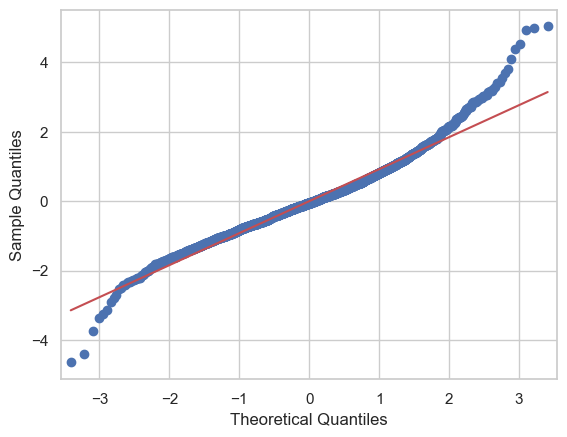

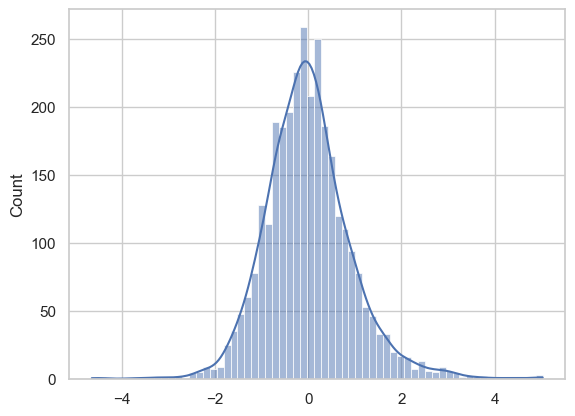

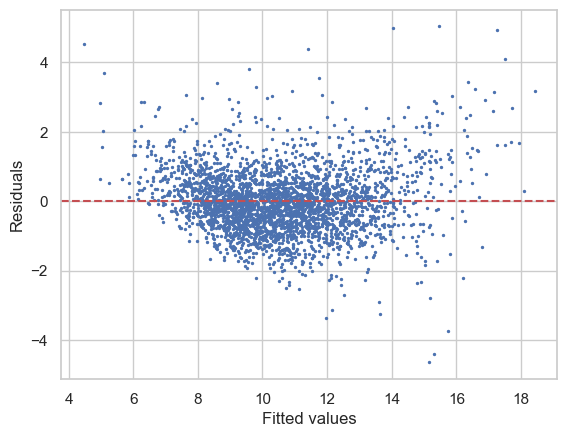

Mean Absolute Error: 0.6877308209517232
Root Mean Squared Error: 0.9217632221655903


In [105]:
X_inter = df[intermediary]
X_inter = X_inter - X_inter.mean()
X_inter = sm.add_constant(X_inter)
y = df[primary_dv]
model = sm.OLS(y, X_inter).fit()
#summary
print(model.summary())

#plot residuals on QQ
residuals = model.resid
fig = sm.qqplot(residuals, line='s')
plt.show()

#plot residuals on histogram
sns.histplot(residuals, kde=True)
plt.show()

#plot residuals on scatter, small dots
plt.scatter(model.fittedvalues, residuals, s=2)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

mae = np.mean(np.abs(residuals))
print(f'Mean Absolute Error: {mae}')
rmse = np.sqrt(np.mean(residuals**2))
print(f'Root Mean Squared Error: {rmse}')




In [89]:
X = df[intermediary]
y = df[primary_dv]
#center X
X = X - X.mean()
#add constant
X = sm.add_constant(X)

# Linear Regression and Assumptions Check

                       Results: Ordinary least squares
Model:               OLS                       Adj. R-squared:      0.833    
Dependent Variable:  brfss_diabetes_ageadjprv  AIC:                 8250.1255
Date:                2024-04-10 13:07          BIC:                 8316.4707
No. Observations:    3076                      Log-Likelihood:      -4114.1  
Df Model:            10                        F-statistic:         1534.    
Df Residuals:        3065                      Prob (F-statistic):  0.00     
R-squared:           0.834                     Scale:               0.85270  
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------------------
const                        10.5643   0.0166 634.5095 0.0000 10.5317 10.5970
structural_internet_adoption -0.2162   0.0062 -34.6925 0.0000 -0.2284 -0.2039
pct_hlth_

,VIF,Tolerance,features
0,1.000,1.000,const
1,5.320,0.190,structural_internet_adoption
2,1.480,0.680,pct_hlth_unins
3,1.430,0.700,brfss_checkup_ageadjprv
4,6.060,0.160,brfss_csmoking_ageadjprv
5,3.180,0.310,brfss_mhlth_ageadjprv
6,2.510,0.400,brfss_obesity_ageadjprv
7,1.210,0.830,pct_age_gte65
8,4.440,0.230,pct_tp_veh_1
9,1.870,0.530,pct_tp_veh_2


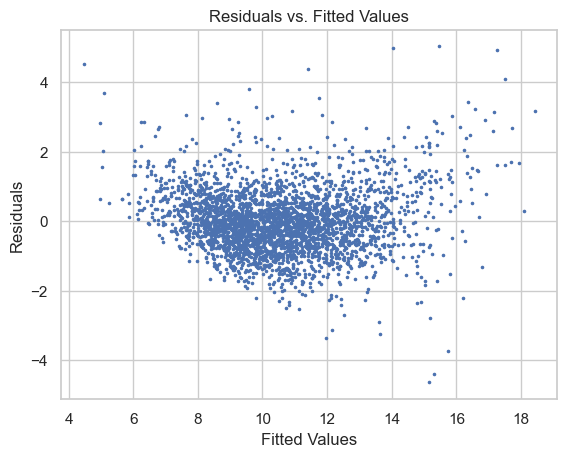

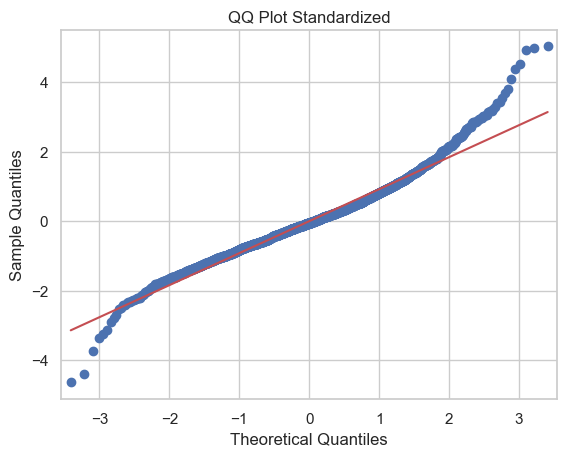

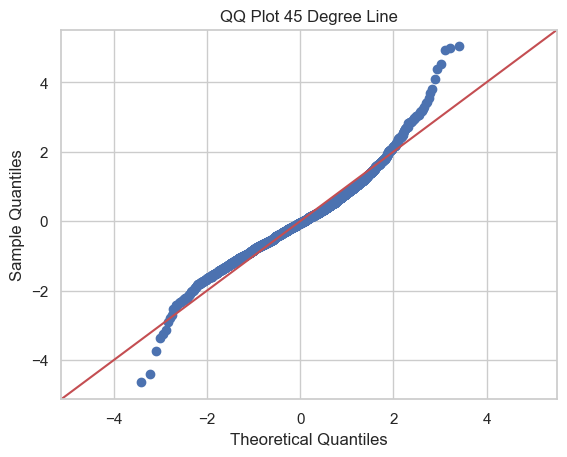

In [90]:
model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns

#Make MAE and RMSE scores 
mae = np.mean(np.abs(results.resid))
rmse = np.sqrt(np.mean(results.resid**2))

#Reg Model Summary, MAE, and VIF display
print(results.summary2())
print("MAE: ", mae)
print("RMSE: ", rmse)
display(vif.round(2))

#Assess for heteroskedasticity and normality of residuals
residuals = results.resid
plt.scatter(results.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ Plot with Standardized line
sm.qqplot(residuals, line='s')
plt.title('QQ Plot Standardized')
plt.show()

#QQ Plot with 45 degree line
sm.qqplot(residuals, line='45')
plt.title('QQ Plot 45 Degree Line')
plt.show()

In [91]:
summary_df = pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0]
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={'index':'feature'})
print(summary_df)

                         feature   coef  std err       t  P>|t|  [0.025  \
0                          const 10.564    0.017 634.509  0.000  10.532   
1   structural_internet_adoption -0.216    0.006 -34.692  0.000  -0.228   
2                 pct_hlth_unins  0.074    0.004  18.861  0.000   0.066   
3        brfss_checkup_ageadjprv  0.049    0.004  10.876  0.000   0.040   
4       brfss_csmoking_ageadjprv -0.210    0.010 -20.931  0.000  -0.230   
5          brfss_mhlth_ageadjprv  0.313    0.014  22.439  0.000   0.286   
6        brfss_obesity_ageadjprv  0.123    0.006  21.185  0.000   0.112   
7                  pct_age_gte65 -0.094    0.004 -23.655  0.000  -0.101   
8                   pct_tp_veh_1  0.015    0.006   2.453  0.014   0.003   
9                   pct_tp_veh_2 -0.043    0.005  -8.601  0.000  -0.052   
10                  pct_tp_veh_3 -0.047    0.005 -10.190  0.000  -0.057   

    0.975]  
0   10.597  
1   -0.204  
2    0.082  
3    0.057  
4   -0.191  
5    0.341  
6    0.1

In [92]:
#create a equation for the model in latex
def latex_eq(coefficients, dv):
    eq = dv + ' = '
    for i in range(len(coefficients)):
        if i == 0:
            eq += str(round(coefficients[i], 3))
        else:
            eq += ' + ' + str(round(coefficients[i], 3)) + ' ' + str(summary_df['feature'][i])
    return eq

print(latex_eq(results.params, dv[0]))


brfss_diabetes_ageadjprv = 10.564 + -0.216 structural_internet_adoption + 0.074 pct_hlth_unins + 0.049 brfss_checkup_ageadjprv + -0.21 brfss_csmoking_ageadjprv + 0.313 brfss_mhlth_ageadjprv + 0.123 brfss_obesity_ageadjprv + -0.094 pct_age_gte65 + 0.015 pct_tp_veh_1 + -0.043 pct_tp_veh_2 + -0.047 pct_tp_veh_3


In [93]:
fit_measures = pd.DataFrame()
fit_measures['MAE'] = [mae]
fit_measures['RMSE'] = [rmse]
fit_measures['R2'] = [results.rsquared]
fit_measures['Adj. R2'] = [results.rsquared_adj]
fit_measures['F-statistic'] = [results.fvalue]
fit_measures['p-value'] = [results.f_pvalue]
fit_measures['AIC'] = [results.aic]
fit_measures['BIC'] = [results.bic]
fit_measures['Log-Likelihood'] = [results.llf]
fit_measures['df_resid'] = [results.df_resid]
fit_measures['df_model'] = [results.df_model]

display(fit_measures.round(2))

,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,df_resid,df_model
0,0.690,0.920,0.830,0.830,1534.430,0.000,8250.130,8316.470,-4114.060,3065.000,10.000


## Outlier Assessment and Removal 

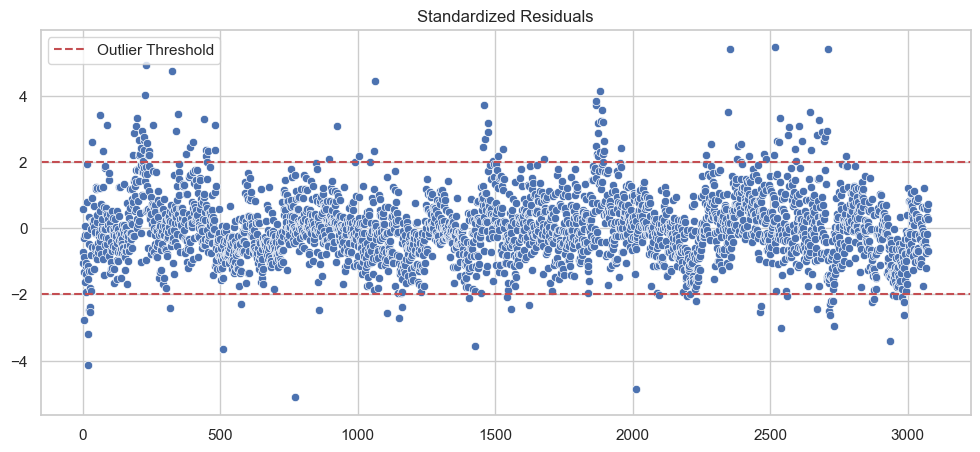

False    2866
True      210
Name: outliers, dtype: int64

0.0013003901170351106
3076


In [94]:
#outlier detection Cook's Distance
influence = OLSInfluence(results)
standardized_residuals = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance

plt.figure(figsize=(12, 5))
sns.scatterplot(x=range(len(standardized_residuals)), y=standardized_residuals)
plt.axhline(y=2, color='r', linestyle='--', label='Outlier Threshold')
plt.axhline(y=-2, color='r', linestyle='--')
plt.title('Standardized Residuals')
plt.legend()
plt.show()

df_outliers = df.copy()
df_outliers['standardized_residuals'] = standardized_residuals
df_outliers['leverage'] = leverage
df_outliers['cooks_d'] = cooks_d[0]

#identify outliers using Cook's Distance 4/(n-k-1)
df_outliers['outliers'] = df_outliers['cooks_d'] > (4/(len(df_outliers)-len(iv)-1))
df_outliers[df_outliers['outliers'] == True]
display(df_outliers['outliers'].value_counts())

print(4/len(df_outliers))
print(len(df_outliers))


In [97]:
# remove outliers
df_no_outliers = df_outliers[df_outliers['outliers'] == False]
#drop outlier columns
df_no_outliers = df_no_outliers.drop(columns=['standardized_residuals', 'leverage', 'cooks_d', 'outliers'])
# set x and y with outliers removed
X = df_no_outliers[intermediary]
y = df_no_outliers[primary_dv]
#center X
X = X - X.mean()
#add constant
X = sm.add_constant(X)

                       Results: Ordinary least squares
Model:               OLS                       Adj. R-squared:      0.875    
Dependent Variable:  brfss_diabetes_ageadjprv  AIC:                 6218.4048
Date:                2024-04-10 13:08          BIC:                 6283.9722
No. Observations:    2866                      Log-Likelihood:      -3098.2  
Df Model:            10                        F-statistic:         1998.    
Df Residuals:        2855                      Prob (F-statistic):  0.00     
R-squared:           0.875                     Scale:               0.51069  
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------------------
const                        10.4057   0.0133 779.5278 0.0000 10.3795 10.4319
structural_internet_adoption -0.1920   0.0053 -36.4641 0.0000 -0.2024 -0.1817
pct_hlth_

,VIF,Tolerance,features
0,1.000,1.000,const
1,5.170,0.190,structural_internet_adoption
2,1.450,0.690,pct_hlth_unins
3,1.460,0.680,brfss_checkup_ageadjprv
4,6.600,0.150,brfss_csmoking_ageadjprv
5,3.490,0.290,brfss_mhlth_ageadjprv
6,2.350,0.430,brfss_obesity_ageadjprv
7,1.220,0.820,pct_age_gte65
8,9.340,0.110,pct_tp_veh_1
9,3.470,0.290,pct_tp_veh_2


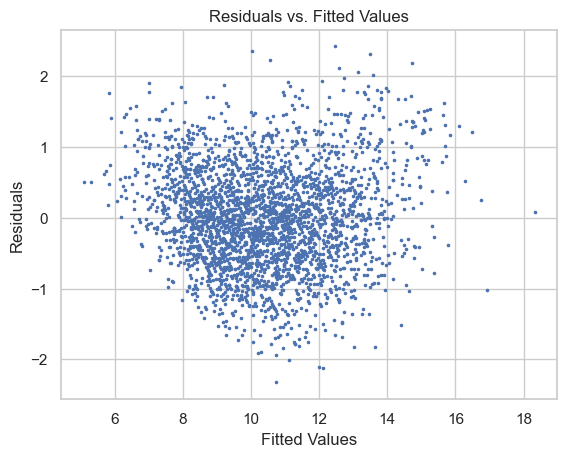

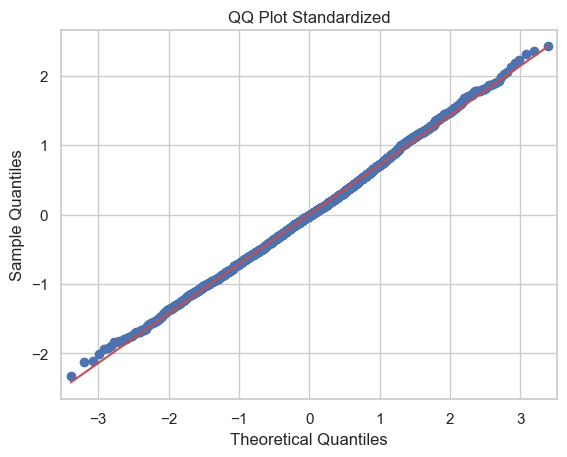

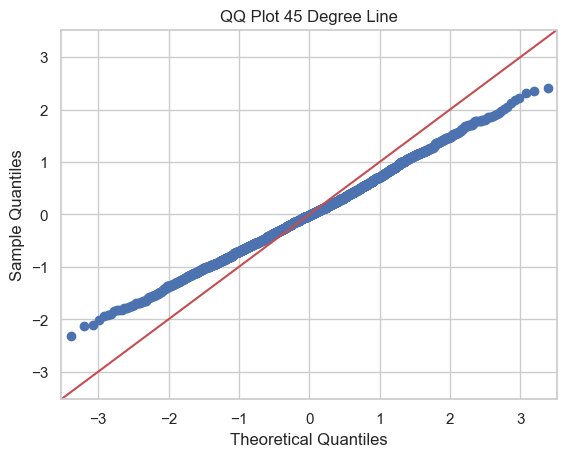

In [98]:
model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns

#Make MAE and RMSE scores 
mae = np.mean(np.abs(results.resid))
rmse = np.sqrt(np.mean(results.resid**2))

#Reg Model Summary, MAE, and VIF display
print(results.summary2())
print("MAE: ", mae)
print("RMSE: ", rmse)
display(vif.round(2))

#Assess for heteroskedasticity and normality of residuals
residuals = results.resid
plt.scatter(results.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ Plot with Standardized line
sm.qqplot(residuals, line='s')
plt.title('QQ Plot Standardized')
plt.show()

#QQ Plot with 45 degree line
sm.qqplot(residuals, line='45')
plt.title('QQ Plot 45 Degree Line')
plt.show()

In [99]:
fit_measures_2 = pd.DataFrame()
fit_measures_2['MAE'] = [mae]
fit_measures_2['RMSE'] = [rmse]
fit_measures_2['R2'] = [results.rsquared]
fit_measures_2['Adj. R2'] = [results.rsquared_adj]
fit_measures_2['F-statistic'] = [results.fvalue]
fit_measures_2['p-value'] = [results.f_pvalue]
fit_measures_2['AIC'] = [results.aic]
fit_measures_2['BIC'] = [results.bic]
fit_measures_2['Log-Likelihood'] = [results.llf]
fit_measures_2['df_resid'] = [results.df_resid]
fit_measures_2['df_model'] = [results.df_model]

print('OLS')
display(fit_measures.round(2))
print('OLS with outliers removed')
display(fit_measures_2.round(2))

OLS


,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,df_resid,df_model
0,0.690,0.920,0.830,0.830,1534.430,0.000,8250.130,8316.470,-4114.060,3065.000,10.000


OLS with outliers removed


,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,df_resid,df_model
0,0.570,0.710,0.870,0.870,1998.470,0.000,6218.400,6283.970,-3098.200,2855.000,10.000


In [100]:
#Outlier remove Model coefficients

summary_df = pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0]
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={'index':'feature'})
print(summary_df)

                         feature   coef  std err       t  P>|t|  [0.025  \
0                          const 10.406    0.013 779.528  0.000  10.380   
1   structural_internet_adoption -0.192    0.005 -36.464  0.000  -0.202   
2                 pct_hlth_unins  0.090    0.003  25.846  0.000   0.084   
3        brfss_checkup_ageadjprv  0.070    0.004  17.900  0.000   0.062   
4       brfss_csmoking_ageadjprv -0.184    0.009 -20.341  0.000  -0.202   
5          brfss_mhlth_ageadjprv  0.309    0.012  26.003  0.000   0.286   
6        brfss_obesity_ageadjprv  0.107    0.005  22.276  0.000   0.097   
7                  pct_age_gte65 -0.092    0.003 -27.336  0.000  -0.098   
8                   pct_tp_veh_1 -0.014    0.008  -1.814  0.070  -0.028   
9                   pct_tp_veh_2 -0.067    0.006 -11.029  0.000  -0.079   
10                  pct_tp_veh_3 -0.060    0.006 -10.172  0.000  -0.071   

    0.975]  
0   10.432  
1   -0.182  
2    0.097  
3    0.077  
4   -0.166  
5    0.332  
6    0.1